# Project

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  int64  
 1   Checkup                       308854 non-null  int64  
 2   Exercise                      308854 non-null  int64  
 3   Heart_Disease                 308854 non-null  int64  
 4   Skin_Cancer                   308854 non-null  int64  
 5   Other_Cancer                  308854 non-null  int64  
 6   Depression                    308854 non-null  int64  
 7   Diabetes                      308854 non-null  int64  
 8   Arthritis                     308854 non-null  int64  
 9   Sex                           308854 non-null  int64  
 10  Age_Category                  308854 non-null  int64  
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)               

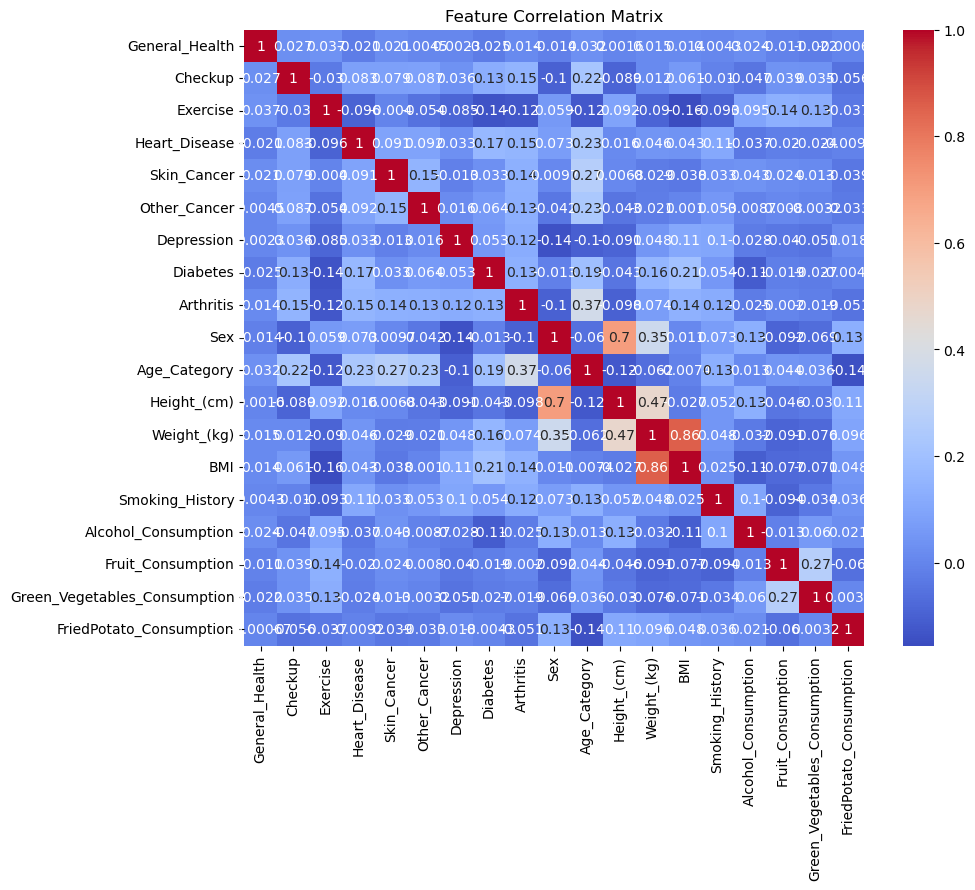

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     85101
           1       0.20      0.23      0.21      7556

    accuracy                           0.86     92657
   macro avg       0.56      0.57      0.57     92657
weighted avg       0.87      0.86      0.87     92657

k-NN Performance:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     85101
           1       0.26      0.11      0.16      7556

    accuracy                           0.90     92657
   macro avg       0.59      0.54      0.55     92657
weighted avg       0.87      0.90      0.88     92657

MLP Performance:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     85101
           1       0.49      0.04      0.07      7556

    accuracy                           0.92     92657
   macro avg       0.71      0.52      0.51     92657
weighted avg

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

# Step 1: Load Data
data_path = "CVD_cleaned.csv"  # Replace with actual dataset path
data = pd.read_csv(data_path)

# Encode categorical data
label_encoders = {}
for column in ["General_Health", "Checkup", "Exercise", "Heart_Disease", "Skin_Cancer", "Other_Cancer", "Depression", "Diabetes", "Arthritis", "Sex", "Age_Category", "Smoking_History"]:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Step 2: Data Understanding
print("Dataset Overview:")
print(data.info())
print(data.describe())

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Step 3: Handle Missing Values
# Strategy 1: Mean Imputation
imputer_mean = SimpleImputer(strategy='mean')
data_mean_imputed = pd.DataFrame(imputer_mean.fit_transform(data), columns=data.columns)

# Strategy 2: Median Imputation
imputer_median = SimpleImputer(strategy='median')
data_median_imputed = pd.DataFrame(imputer_median.fit_transform(data), columns=data.columns)

# Step 4: Data Normalization
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_mean_imputed), columns=data.columns)

# Ensure Heart_Disease is categorical after normalization
data_normalized["Heart_Disease"] = data["Heart_Disease"]

# Step 5: Data Splitting
X = data_normalized.drop("Heart_Disease", axis=1)
y = data_normalized["Heart_Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Supervised Learning
# Decision Tree
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred_tree))

# k-NN
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
print("k-NN Performance:")
print(classification_report(y_test, y_pred_knn))

# Multi-layer Perceptron
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)
print("MLP Performance:")
print(classification_report(y_test, y_pred_mlp))

# Step 7: Unsupervised Learning
# k-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.labels_
if len(set(kmeans_labels)) > 1:
    print("k-Means Silhouette Score:", silhouette_score(X, kmeans_labels))
else:
    print("k-Means: Only one cluster found. Cannot compute Silhouette Score.")

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjusted parameters for better clustering
dbscan_labels = dbscan.fit_predict(X)
if len(set(dbscan_labels)) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(X, dbscan_labels))
else:
    print("DBSCAN: Only one cluster found. Cannot compute Silhouette Score.")

# Visualizing Clusters
if len(set(kmeans_labels)) > 1:
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans_labels, cmap='viridis')
    plt.title("k-Means Clustering")
    plt.show()
else:
    print("k-Means: Clustering visualization skipped due to a single cluster.")

if len(set(dbscan_labels)) > 1:
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=dbscan_labels, cmap='viridis')
    plt.title("DBSCAN Clustering")
    plt.show()
else:
    print("DBSCAN: Clustering visualization skipped due to a single cluster.")
